In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
%load_ext tensorboard
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

Num GPUs Available:  0


In [2]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Conv1D, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional, RepeatVector, TimeDistributed
from keras import regularizers
from datetime import datetime
import time
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Data generation

In [3]:
import cars_generate
from cars_generate import cars_generating

def data_feature_generation(sample_size, max_feature):
    cars= cars_generating(max_feature,640)
    data= cars.generate_batch(sample_size) 
    x, y= data[0],data[1]
    return x.reshape((-1,640)), y.reshape((-1,640))

def split_data(sample_size, split_size, n_batch=14):
    x_train, x_test, y_train, y_test= [],[],[],[]
    n_samples=int(sample_size/n_batch)
    for i in range(1,n_batch+1):
        x,y= data_feature_generation(n_samples,i)
        x_train.append(x[:int(split_size*n_samples)])
        x_test.append(x[int(split_size*n_samples):])
        y_train.append(y[:int(split_size*n_samples)])
        y_test.append(y[int(split_size*n_samples):])
    x_train, y_train=np.array(x_train), np.array(y_train)
    x_test, y_test= np.array(x_test), np.array(y_test)
    return x_train.reshape((-1,640)), x_test.reshape((-1,640)), y_train.reshape((-1,640)), y_test.reshape((-1,640))
 
def shuffle_data(x_train, x_test,y_train, y_test):
    index_train=random.sample([i for i in range(len(x_train))], len(x_train))
    index_test=random.sample([i for i in range(len(x_test))], len(x_test))
    return x_train[index_train], x_test[index_test],y_train[index_train], y_test[index_test]

def generate_csv(x, name):
    x=pd.DataFrame(x)
    return x.to_csv(name+'.csv')

In [4]:
# x_train, x_test, y_train, y_test=split_data(20000, 2/3, 15)
# x_train, x_test, y_train, y_test=shuffle_data(x_train, x_test, y_train, y_test)

# upload csv

In [5]:
import os
# dire= os.mkdir('Data')
# generate_csv(x_train.reshape((-1,640)), 'Data/x_train')
# generate_csv(y_train.reshape((-1,640)), 'Data/y_train')
# generate_csv(x_test.reshape((-1,640)),'Data/x_test')
# generate_csv(y_test.reshape((-1,640)), 'Data/y_test')

## Download Data

In [6]:
x_train= pd.read_csv('Data/x_train.csv', index_col=0).to_numpy()
x_test= pd.read_csv('Data/x_test.csv', index_col=0).to_numpy()
y_train= pd.read_csv('Data/y_train.csv',index_col=0).to_numpy()
y_test= pd.read_csv('Data/y_test.csv',index_col=0).to_numpy()

In [7]:
x_train.shape, x_test.shape

((13320, 640), (6675, 640))

the time neded for executing this cose is: 0.24857211112976074


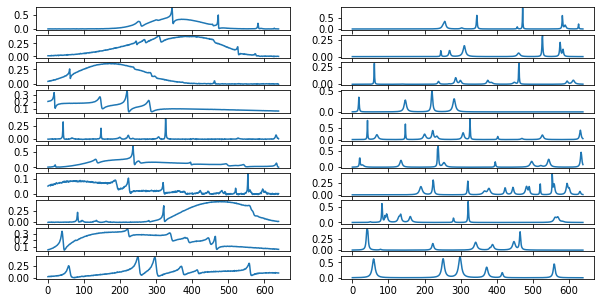

In [8]:
t0= time.time()
f, a= plt.subplots(10,2, figsize= (10,5))
for i in range(len(a)):
  a[i,0].plot(x_train[i*200])
  a[i,1].plot(y_train[i*200])
print("the time neded for executing this cose is: {}".format(time.time()-t0))

In [9]:
x_train, y_train= x_train.reshape((-1,640,1)), y_train.reshape((-1,640,1))
x_train.shape, y_train.shape

((13320, 640, 1), (13320, 640, 1))

# LSTM

### LSTM architecture

In [69]:
# define ustome los: SPectral similarity value ssv
def custom_loss(yTrue,yPred):
    d= K.sqrt(K.mean(K.square(yPred - yTrue), axis=None))
    x=yTrue
    y=yPred
    mx = K.mean(x, axis=1, keepdims=True)
    my = K.mean(y, axis=1, keepdims=True)
    xm, ym = x-mx, y-my
    r_num = K.mean(tf.multiply(xm,ym))        
    r_den = K.std(xm) * K.std(ym)
    r=r_num/r_den
    ssv= K.sqrt(K.square(d)+1-K.square(r))
    return

In [ ]:
# define ustome los: SPectral similarity value ssv
def custom_loss(yTrue,yPred):
    d= tf.keras.metrics.RootMeanSquaredError(yTrue, yPred)
    x=yTrue
    y=yPred
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    r=r_num/r_den
    ssv= tf.sqrt(d**2+1-r**2)
    return

In [10]:
 def correlationMetric(x, y, axis=-2):
  """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
  x = tf.convert_to_tensor(x)
  y = tf.convert_to_tensor(y)
  n = tf.cast(tf.shape(x)[axis], x.dtype)
  xsum = tf.reduce_sum(x, axis=axis)
  ysum = tf.reduce_sum(y, axis=axis)
  xmean = xsum / n
  ymean = ysum / n
  xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
  yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
  cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
  corr = cov / tf.sqrt(xvar * yvar)
  return tf.constant(1.0, dtype=x.dtype) - corr

correlationMetric(tf.constant([[0.0, 1.0, 2.0]]), tf.constant([[1.0, 3.0, 2.0]]), axis=-1)
# correlationMetric(tf.constant([[0.0, 2.0, 1.0]]), tf.constant([[1.0, 3.0, 2.0]]), axis=-1)
# correlationMetric(tf.constant([[0.0], [2.0], [1.0]]), tf.constant([[1.0], [3.0], [2.0]]), axis=-2)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5], dtype=float32)>

In [11]:
np.correlate(np.array([0.0, 1.0, 2.0]), np.array([1.0, 3.0, 2.0]))

array([7.])

In [26]:
def correlationLoss(x,y, axis=-2):
    """Loss function that maximizes the pearson correlation coefficient between the predicted values and the labels,
    while trying to have the same mean and variance"""
    x = tf.convert_to_tensor(x)
    y = tf.convert_to_tensor(y)
    n = tf.cast(tf.shape(x)[1], x.dtype)
    xsum = tf.reduce_sum(x, axis=1, keepdims=True)
    ysum = tf.reduce_sum(y, axis=1, keepdims=True)
    xmean = xsum / n
    ymean = ysum / n
#     xsqsum = tf.reduce_sum( tf.math.squared_difference(x, xmean))
    xstd= K.std(x, axis=1)
    ystd= K.std(y, axis=1)
#     ysqsum = tf.reduce_sum( tf.math. squared_difference(y, ymean))
    cov = K.sum( (x - xmean) * (y - ymean), axis=1)/n
#     corr = cov / tf.sqrt(xsqsum * ysqsum) 
    corr= cov/(xstd*ystd)
    sqdif = tf.reduce_sum(tf.math.squared_difference(x, y), axis=1) / n #/ tf.sqrt(ysqsum / n)
    return K.sqrt(K.mean((1 - corr**2 + sqdif), axis=1))
t1,t2 = tf.constant([[[0.0], [1.0]], [[1.0],[2.0]], [[3.0],[3.0]]]), tf.constant(
    [[[0.0],[0.0]], [[1.0],[1.0]], [[2.0],[2.0]]])
print(correlationLoss(t1,t2)) 
# print(correlationMetric(t1,t2))
t1.shape

tf.Tensor([nan nan nan], shape=(3,), dtype=float32)


TensorShape([3, 2, 1])

In [32]:
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1) 

In [33]:
my_loss_fn(t1, t2)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.],
       [1., 1.]], dtype=float32)>

In [19]:
correlationLoss(x_train, y_train)

InvalidArgumentError: Incompatible shapes: [13320,640,1] vs. [13320,1] [Op:Sub]

In [75]:
d1=tf.random.uniform([2,10,1], 0,5, dtype=tf.dtypes.int32)
d1

<tf.Tensor: shape=(2, 10, 1), dtype=int32, numpy=
array([[[3],
        [3],
        [4],
        [3],
        [0],
        [4],
        [3],
        [0],
        [3],
        [0]],

       [[0],
        [4],
        [4],
        [3],
        [0],
        [3],
        [1],
        [4],
        [1],
        [0]]], dtype=int32)>

In [144]:
K.mean(tf.dtypes.cast(d1, tf.float32), axis=-1
      )

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[3., 3., 4., 3., 0., 4., 3., 0., 3., 0.],
       [0., 4., 4., 3., 0., 3., 1., 4., 1., 0.]], dtype=float32)>

In [80]:
d1-K.mean(d1, axis=1, keepdims=True
      )

<tf.Tensor: shape=(2, 10, 1), dtype=int32, numpy=
array([[[ 1],
        [ 1],
        [ 2],
        [ 1],
        [-2],
        [ 2],
        [ 1],
        [-2],
        [ 1],
        [-2]],

       [[-2],
        [ 2],
        [ 2],
        [ 1],
        [-2],
        [ 1],
        [-1],
        [ 2],
        [-1],
        [-2]]], dtype=int32)>

In [63]:
np.mean(np.array([1.7, 2]))

1.85

In [17]:
t1-K.sum(t1, axis=1, keepdims=True)

<tf.Tensor: shape=(3, 1, 1), dtype=float32, numpy=
array([[[0.]],

       [[0.]],

       [[0.]]], dtype=float32)>

In [30]:
print(K.sqrt(K.mean(K.square((tf.convert_to_tensor(x_train)- tf.convert_to_tensor(y_train))), axis=None)))

tf.Tensor(0.21947718777626118, shape=(), dtype=float64)


In [67]:
d=K.mean(tf.convert_to_tensor(x_train), axis=1, keepdims=True
      )

In [68]:
tf.convert_to_tensor(x_train)-d

<tf.Tensor: shape=(13320, 640, 1), dtype=float64, numpy=
array([[[-0.11323412],
        [-0.11243229],
        [-0.11039366],
        ...,
        [-0.11440338],
        [-0.1122202 ],
        [-0.11414331]],

       [[-0.18223744],
        [-0.1835298 ],
        [-0.18398555],
        ...,
        [-0.02336483],
        [-0.02488805],
        [-0.01730418]],

       [[-0.0056524 ],
        [-0.00303689],
        [ 0.00046341],
        ...,
        [-0.20564833],
        [-0.20750301],
        [-0.20611949]],

       ...,

       [[-0.02567541],
        [-0.02521495],
        [-0.02426488],
        ...,
        [-0.0957285 ],
        [-0.09431123],
        [-0.09634083]],

       [[-0.26590159],
        [-0.26998871],
        [-0.26288404],
        ...,
        [ 0.13281405],
        [ 0.13415196],
        [ 0.13769745]],

       [[ 0.15391169],
        [ 0.16150653],
        [ 0.16241224],
        ...,
        [-0.29891299],
        [-0.29567173],
        [-0.29775291]]])>

In [72]:
custom_loss(x_train, y_train)

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

In [83]:
from tensorflow.python import debug as tf_debug
K.clear_session()
sess = tf.compat.v1.keras.backend.get_session()
sess = tf_debug.LocalCLIDebugWrapperSession(sess)
tf.compat.v1.keras.backend.set_session(sess)
steps= 640
feature=1
logdir_lstm = "logs/scalars_lstm/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir_lstm)
es =tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6, mode= 'min', min_delta=0.0001, verbose=1)
mc = ModelCheckpoint('custom_lstm.h5', monitor='val_loss', mode='min', save_best_only=True)
rmse=tf.keras.metrics.RootMeanSquaredError(name='rmse')
tf.keras.backend.clear_session()
Model=Sequential()
Model.add(LSTM(units=50, return_sequences=True, input_shape=(steps,feature)))
Model.add(Dropout(0.2))
Model.add(LSTM(units=30, return_sequences=True))
Model.add(Dropout(0.2))
Model.add(LSTM(units=30, return_sequences=True))
Model.add(Dropout(0.2))
Model.add(TimeDistributed(Dense(units=1)))
Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss= custom_loss, metrics=[rmse])
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 640, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 640, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 640, 30)           9720      
_________________________________________________________________
dropout_1 (Dropout)          (None, 640, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 640, 30)           7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 640, 30)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 640, 1)            3

In [84]:
history_lstm= Model.fit(x_train, y_train, epochs=50, 
                       batch_size=128, verbose= 2, callbacks=[es, mc, tb_callback], validation_split=0.2)

Epoch 1/50


ValueError: in user code:

    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:150 __call__
        return losses_utils.compute_weighted_loss(
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/keras/utils/losses_utils.py:106 compute_weighted_loss
        losses = ops.convert_to_tensor_v2(losses)
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1377 convert_to_tensor_v2
        return convert_to_tensor(
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1499 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:338 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:263 constant
        return _constant_impl(value, dtype, shape, name, verify_shape=False,
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:280 _constant_impl
        tensor_util.make_tensor_proto(
    /home/mohamed-zorgane/Project/internship/lib/python3.8/site-packages/tensorflow/python/framework/tensor_util.py:444 make_tensor_proto
        raise ValueError("None values not supported.")

    ValueError: None values not supported.


### Evauate the lstm model with RMSE and difference areas

In [14]:
from keras.models import load_model
saved_model_lstm = load_model('lstm.h5')

In [15]:
x_test, y_test= x_test.reshape((-1,640,1)), y_test.reshape((-1,640,1))
LSTM_valuation=saved_model_lstm.evaluate(x_test, y_test, batch_size=128, verbose=2)
LSTM_valuation

53/53 - 9s - loss: 3.6201e-04 - rmse: 0.0190


[0.0003620060160756111, 0.019026456400752068]

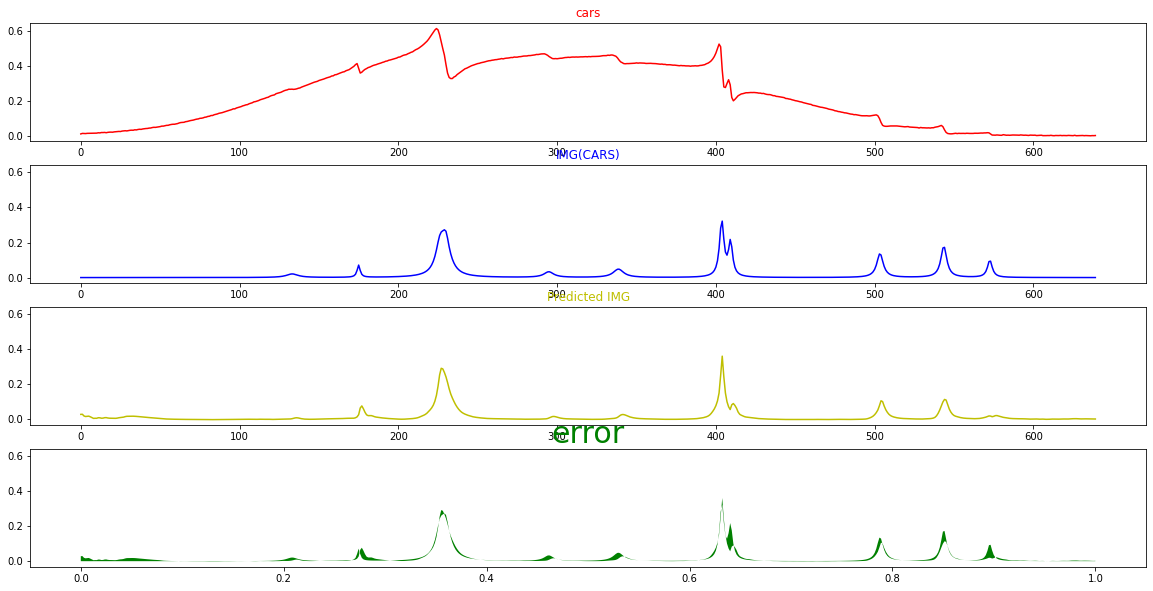

In [27]:
nu= np.linspace(0,1,640)
x_val, y_val= x_test[1].reshape((1,640,1)), y_test[1].reshape((1,640,1))
y_prd= saved_model_lstm.predict(x_val)
f, ax=plt.subplots(4,1, sharey=True, figsize=(20,10))
ax[0].plot(x_val[0,:,0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(y_val[0,:,0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(y_prd[0,:,0], c='y')
ax[2].set_title('Predicted IMG', c='y')
ax[3].fill_between(nu,y_val[0,:,0],y_prd[0,:,0], facecolor='green')
ax[3].set_title('error', c='green', fontsize=30)
plt.show()

In [38]:
# we will use the difference of areas between the predicted  and the reel data
def metric(x,y):
    x,y= x.reshape((-1,640)), y.reshape((-1,640))
    a= 0
    for i in range(len(x)):
        for j in range(x.shape[1]-1):
            a+=np.abs((x[i,j+1]+x[i,j])-(y[i,j+1]+y[i,j]))/2
    return a/len(x)

In [29]:
y_hat= saved_model_lstm.predict(x_test)
metric= metric(x_test, y_hat)
metric

94.57634345776997

### Random prediction

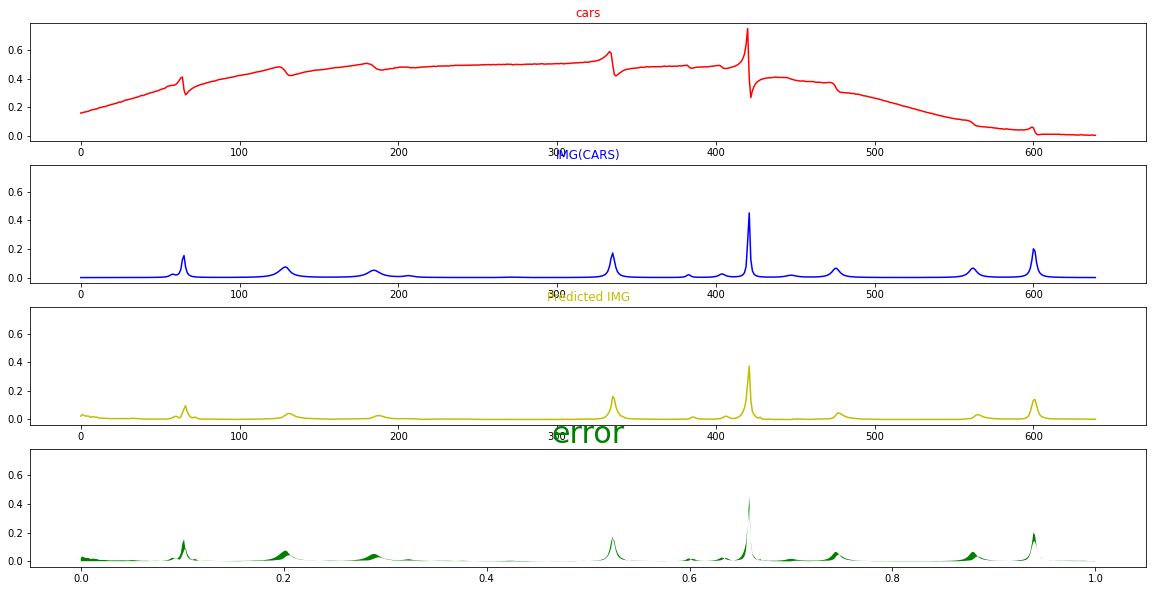

In [44]:
cars=cars_generating(15,640)
data= cars.generate_batch(1)
nu=cars.nu
x= data[0]
y=data[1]
x_gen, y_gen= x.reshape((-1,640,1)), y.reshape((-1,640,1))
y_pred=saved_model_lstm.predict(x_gen)
f, ax=plt.subplots(4,1, sharey=True, figsize=(20,10))
ax[0].plot(x_gen[0,:,0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(y_gen[0,:,0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(y_pred[0,:,0], c='y')
ax[2].set_title('Predicted IMG', c='y')
ax[3].fill_between(nu,y_gen[0,:,0],y_pred[0,:,0], facecolor='green')
ax[3].set_title('error', c='green', fontsize=30)
plt.show()

# CNN+LSTM #

### Model Architecture

In [33]:
logdir2 = "logs/scalars/CNN_LSTM" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir2)
es1 =tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode= 'min', min_delta=0.0001)
rmse= tf.keras.metrics.RootMeanSquaredError()
mc2 = ModelCheckpoint('CNN+LSTM.h5', monitor='val_loss', mode='min', save_best_only=True)
tf.keras.backend.clear_session()
input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))
conv1 = Conv1D(filters=128,
               kernel_size=32,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
conv2= Conv1D(filters=64, kernel_size=16, activation='relu', padding='same')(conv1)
conv3= Conv1D(filters=16, kernel_size=8, activation='relu', padding='same')(conv2)
conv4= Conv1D(filters=8, kernel_size=4, activation='relu', padding='same')(conv3)
lstm1 = LSTM(50, return_sequences=True)(conv4)
lstm2=LSTM(30,return_sequences=True)(lstm1)
dens1=Dense(30, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1 = 0, l2=0.1))(lstm2)
output_layer = TimeDistributed(Dense(units=1))(dens1)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss= 'mse', metrics=[rmse])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 640, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 640, 128)          4224      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 640, 64)           131136    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 640, 16)           8208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 640, 8)            520       
_________________________________________________________________
lstm (LSTM)                  (None, 640, 50)           11800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 640, 30)          

In [34]:
CNN_LSTM_history= model.fit(x_train, y_train, epochs=50, batch_size=128, verbose=2, 
                         validation_split=0.2, callbacks=[es1, mc2, tb_callback1])

Epoch 1/50
84/84 - 94s - loss: 2.0786 - root_mean_squared_error: 0.0471 - val_loss: 1.3051 - val_root_mean_squared_error: 0.0308
Epoch 2/50
84/84 - 96s - loss: 0.8689 - root_mean_squared_error: 0.0254 - val_loss: 0.5234 - val_root_mean_squared_error: 0.0213
Epoch 3/50
84/84 - 93s - loss: 0.3362 - root_mean_squared_error: 0.0186 - val_loss: 0.1918 - val_root_mean_squared_error: 0.0170
Epoch 4/50
84/84 - 93s - loss: 0.1183 - root_mean_squared_error: 0.0167 - val_loss: 0.0634 - val_root_mean_squared_error: 0.0167
Epoch 5/50
84/84 - 93s - loss: 0.0375 - root_mean_squared_error: 0.0162 - val_loss: 0.0190 - val_root_mean_squared_error: 0.0166
Epoch 6/50
84/84 - 94s - loss: 0.0109 - root_mean_squared_error: 0.0164 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0166
Epoch 7/50
84/84 - 93s - loss: 0.0031 - root_mean_squared_error: 0.0160 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0156
Epoch 8/50
84/84 - 96s - loss: 0.0010 - root_mean_squared_error: 0.0153 - val_loss: 6.3937e-04 - 

### Evaluate the cnn+lstm model with RMSE and difference areas

In [35]:
saved_model_cnn_lstm = load_model('CNN+LSTM.h5')
CNN_LSTM_valuation=saved_model_cnn_lstm.evaluate(x_test, y_test, batch_size=128, verbose=2)
CNN_LSTM_valuation

53/53 - 13s - loss: 1.6202e-04 - root_mean_squared_error: 0.0093


[0.00016201817197725177, 0.009256940335035324]

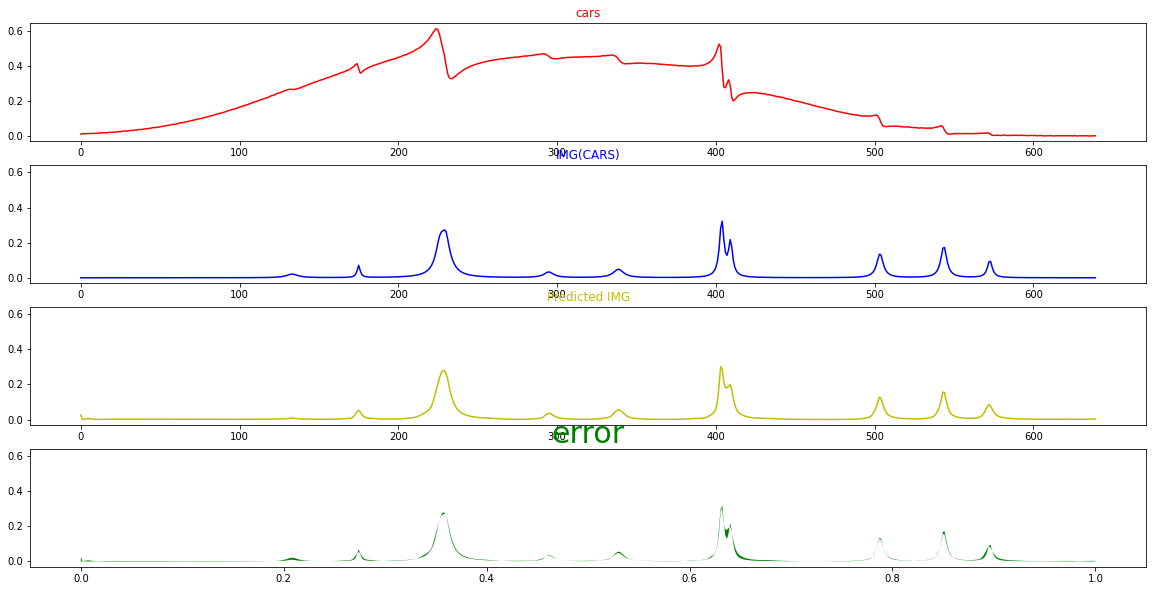

In [36]:
x_val, y_val= x_test[1].reshape((1,640,1)), y_test[1].reshape((1,640,1))
y_prd= saved_model_cnn_lstm.predict(x_val)
f, ax=plt.subplots(4,1, sharey=True, figsize=(20,10))
ax[0].plot(x_val[0,:,0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(y_val[0,:,0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(y_prd[0,:,0], c='y')
ax[2].set_title('Predicted IMG', c='y')
ax[3].fill_between(nu,y_val[0,:,0],y_prd[0,:,0], facecolor='green')
ax[3].set_title('error', c='green', fontsize=30)
plt.show()

In [39]:
y_hat= saved_model_cnn_lstm.predict(x_test)
metric_cnn_lsmt= metric(x_test, y_hat)
metric_cnn_lsmt

94.71644396593815

### Rnadom prediction

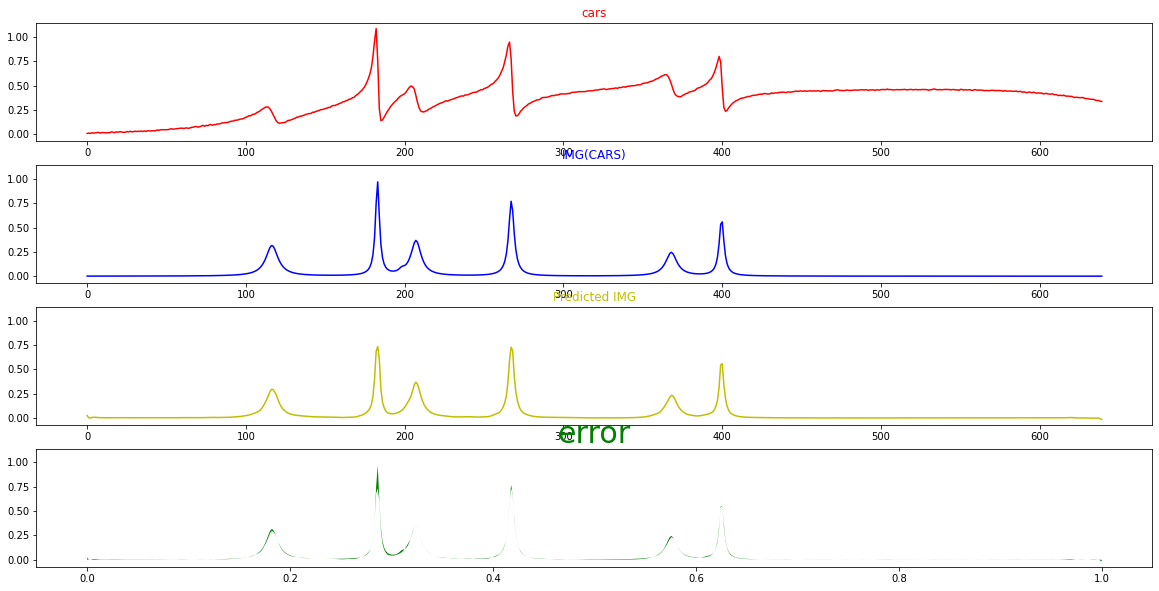

In [41]:
cars=cars_generating(7,640)
data= cars.generate_batch(1)
nu=cars.nu
x= data[0]
y=data[1]
x_gen, y_gen= x.reshape((-1,640,1)), y.reshape((-1,640,1))
y_pred=saved_model_cnn_lstm.predict(x_gen)
f, ax=plt.subplots(4,1, sharey=True, figsize=(20,10))
ax[0].plot(x_gen[0,:,0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(y_gen[0,:,0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(y_pred[0,:,0], c='y')
ax[2].set_title('Predicted IMG', c='y')
ax[3].fill_between(nu,y_gen[0,:,0],y_pred[0,:,0], facecolor='green')
ax[3].set_title('error', c='green', fontsize=30)
plt.show()

# CNN polimi

### Load CNN Model and evaluate it 

In [47]:
saved_model_cnn = load_model('CNN_polimi/model_poli.h5')
x_test, y_test= x_test.reshape((-1,640,1)), y_test.reshape((-1,640))
CNN_valuation=saved_model_cnn.evaluate(x_test, y_test, batch_size=128, verbose=2)
CNN_valuation

53/53 - 5s - loss: 6.0739e-04 - root_mean_squared_error: 0.0232 - accuracy: 0.6712


[0.0006073883851058781, 0.023231834173202515, 0.6711610555648804]

In [54]:
y_hat= saved_model_cnn.predict(x_test)
metric_cnn= metric(x_test, y_hat)
metric_cnn

95.58660545544915

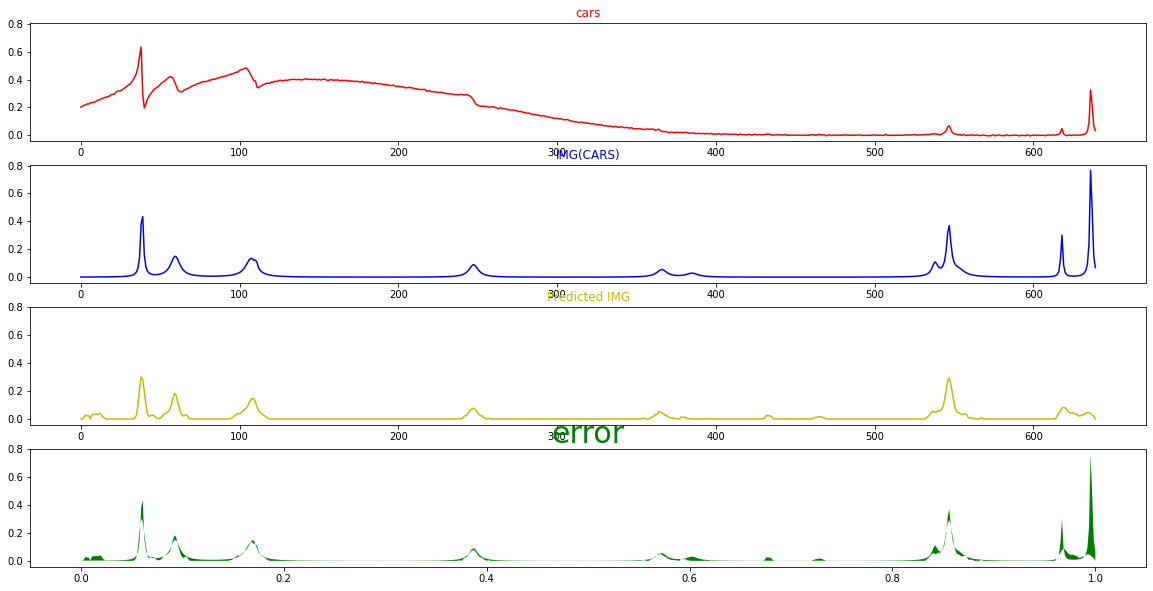

In [48]:
x_val, y_val= x_test[30].reshape((1,640,1)), y_test[30].reshape((1,640))
y_prd= saved_model_cnn.predict(x_val)
f, ax=plt.subplots(4,1, sharey=True, figsize=(20,10))
ax[0].plot(x_val[0,:,0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(y_val[0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(y_prd[0], c='y')
ax[2].set_title('Predicted IMG', c='y')
ax[3].fill_between(nu,y_val[0],y_prd[0], facecolor='green')
ax[3].set_title('error', c='green', fontsize=30)
plt.show()

### Rndom prediction 

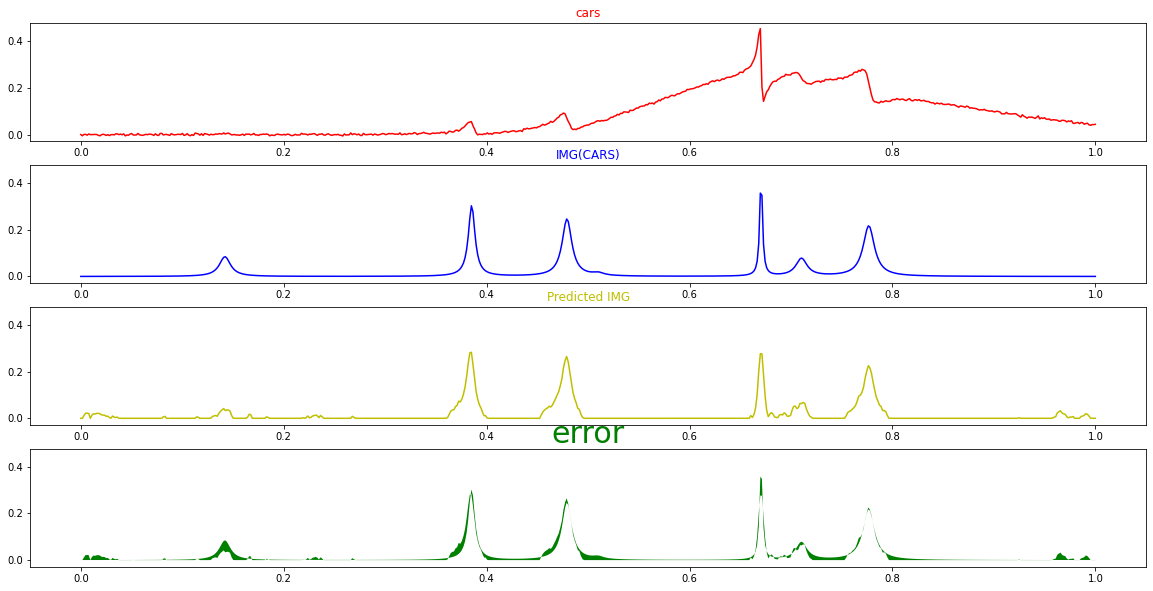

In [53]:
cars=cars_generating(7,640)
data= cars.generate_batch(1)
nu=cars.nu
x= data[0]
y=data[1]
x_gen, y_gen= x.reshape((-1,640,1)), y.reshape((-1,640))
y_pred=saved_model_cnn.predict(x_gen)
f, ax=plt.subplots(4,1, sharey=True, figsize=(20,10))
ax[0].plot(nu,x_gen[0,:,0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(nu,y_gen[0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(nu,y_pred[0], c='y')
ax[2].set_title('Predicted IMG', c='y')
ax[3].fill_between(nu,y_gen[0],y_pred[0], facecolor='green')
ax[3].set_title('error', c='green', fontsize=30)
plt.show()

# history PLot of the models

In [55]:
%tensorboard --logdir logs

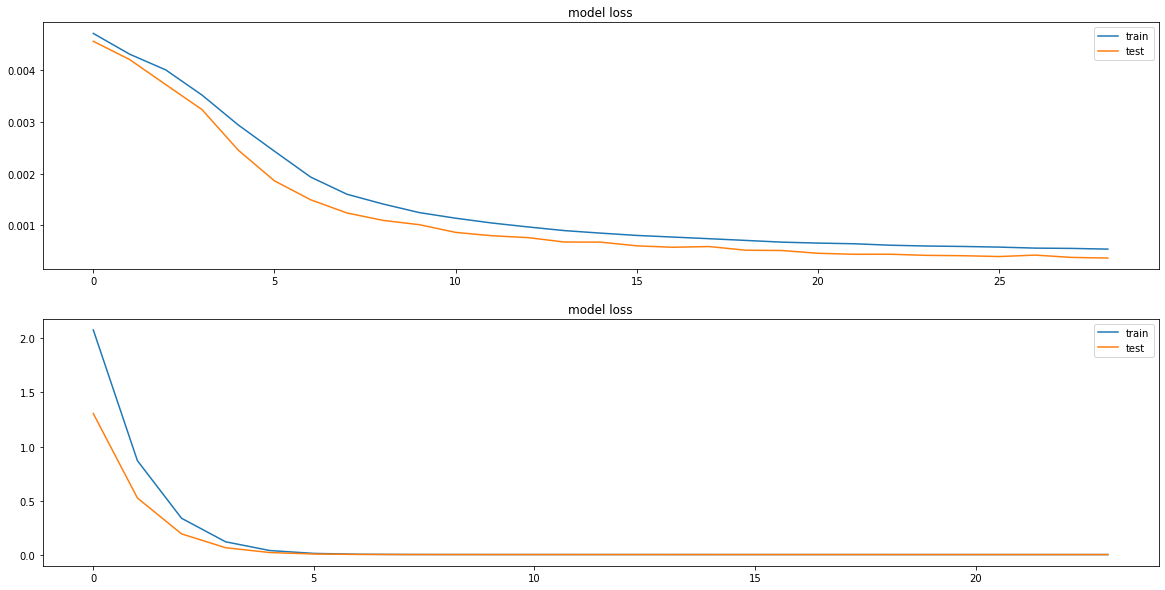

In [61]:
f, ax= plt.subplots(2,1, figsize=(20,10))
ax[0].plot(history_lstm.history['loss'])
ax[0].plot(history_lstm.history['val_loss'])
ax[0].set_title('model loss')
ax[0].legend(['train', 'test'], loc='upper right')

ax[1].plot(CNN_LSTM_history.history['loss'])
ax[1].plot(CNN_LSTM_history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].legend(['train', 'test'], loc='upper right')

plt.show()

# Comparison result